# Dynamics of Bitcoin mining

Some interesting relationships in Bitcoin mining: hardware efficiency, transaction volume and fees, etc. For background see the paper on [Dynamics of Bitcoin mining](
https://arxiv.org/abs/2201.06072).

# Hardware efficiency

In [1]:
import csv
import re
import warnings
import datetime as dt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

plt.rcParams.update({
    "figure.facecolor": (1.0, 1.0, 1.0, 1.0),  # blue  with alpha = 20%
})

miners = []
with open('miners.csv') as datafile:
    reader = csv.DictReader(datafile)
    for rowdict in reader:
        rowdict['Power (kW)'] = float(re.search('([0-9])+',rowdict['Power']).group(0))/1000.0
        rowdict['Hashrate (TH/s)'] = float(re.search('([0-9])+',rowdict['Hashrate']).group(0))
        rowdict['alpha (kWh/TH)']=rowdict['Power (kW)']/(rowdict['Hashrate (TH/s)']*3600)
        rowdict['Date'] = dt.datetime.strptime(rowdict['Date'], '%b %Y').date()
        miners.append(rowdict)

# additional data from https://github.com/crabel99/BTC-Mining-Economics/tree/master/data
# efficiency is in J/TH
with open('miners2.csv') as datafile:
    reader = csv.DictReader(datafile)
    for rowdict in reader:
        if list(rowdict.values())[0].startswith('#'):
            continue
        rowdict['alpha (kWh/TH)']=float(rowdict['Efficiency'])/(3600*1000.0)
        rowdict['Date'] = dt.datetime.strptime(rowdict['Date'], '%d/%m/%Y').date()
        if rowdict['Date'] < pd.to_datetime('2010-09-01').date():
            continue
        miners.append(rowdict)
        
miners_df = pd.DataFrame(miners).set_index('Date')
miners_df.index=pd.to_datetime(miners_df.index)
miners_df.sort_values(by='alpha (kWh/TH)', ascending=False, inplace=True)
miners_df.sort_index(inplace=True)

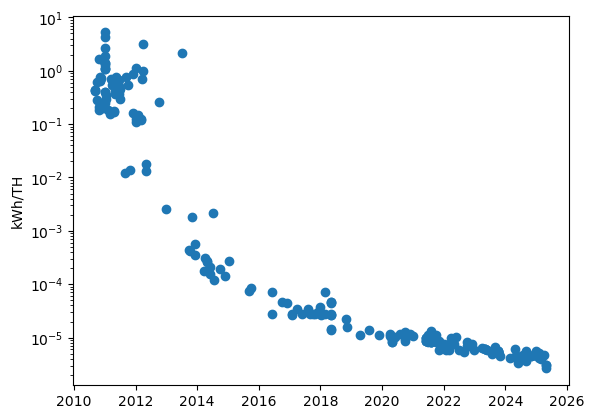

In [2]:
plt.scatter(x=miners_df.index, y=miners_df['alpha (kWh/TH)'])
plt.ylabel('kWh/TH')
plt.yscale('log')

# Mining share of value

In [3]:
rev = pd.read_csv('miners-revenue.csv')
mkt = pd.read_csv('market-cap.csv')
fees = pd.read_csv('transaction-fees-usd.csv')
rev.rename({'bbbbb﻿Timestamp': 'Timestamp'}, axis=1, inplace=True)
rev.set_index('Timestamp', inplace=True)
mkt.set_index('Timestamp', inplace=True)
fees.set_index('Timestamp', inplace=True)

df = mkt.merge(rev, how='outer', on='Timestamp', sort=True)
df = df.merge(fees, how='outer', on='Timestamp', sort=True)
df.index = pd.to_datetime(df.index)
df.interpolate(method='time', inplace=True)

In [4]:
vt = df.apply(lambda row: row['miners-revenue']*365.25/row['market-cap'], axis=1)
vtf = df.apply(lambda row: row['transaction-fees-usd']*365.25/row['market-cap'], axis=1)

Text(0.5, 1.0, 'annual_miner_rev/mkt_cap')

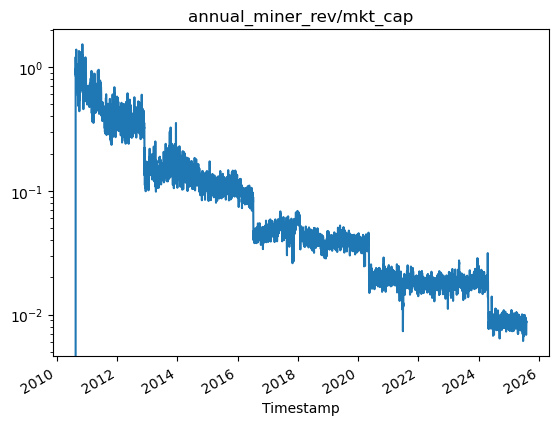

In [5]:
vt.plot()
plt.yscale('log')
plt.title('annual_miner_rev/mkt_cap')

Text(0.5, 1.0, 'annual_fees/mkt_cap')

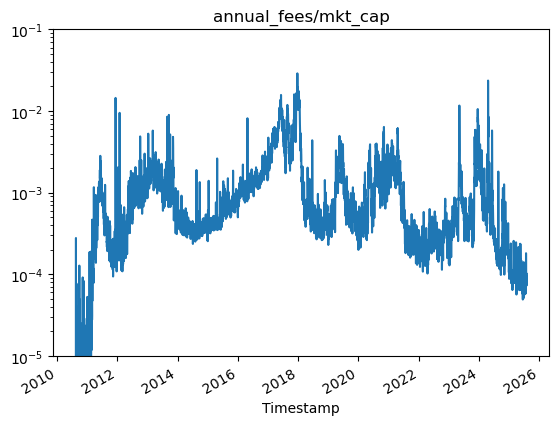

In [6]:
vtf.plot()
plt.yscale('log')
plt.ylim([1e-5,0.1])
plt.title('annual_fees/mkt_cap')

Text(0.5, 1.0, 'fees/miner_rev')

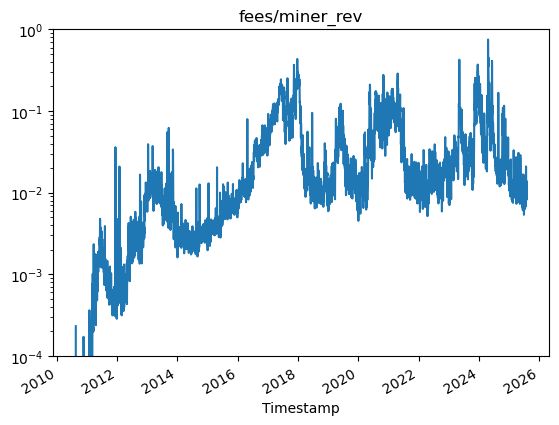

In [7]:
fr = df.apply(lambda row: row['transaction-fees-usd']/row['miners-revenue'], axis=1)
fr.plot()
plt.yscale('log')
plt.ylim([1e-4,1])
plt.title('fees/miner_rev')

# Fees as congestion price

In [8]:
txn_btc = pd.read_csv('estimated-transaction-volume.csv')
txn_btc['Timestamp'] = pd.to_datetime(txn_btc['Timestamp'])
txn_btc.set_index('Timestamp', inplace=True)

fees_btc = pd.read_csv('transaction-fees.csv')
fees_btc['Timestamp'] = pd.to_datetime(fees_btc['Timestamp'])
fees_btc.set_index('Timestamp', inplace=True)

txn_num = pd.read_csv('n-transactions.csv')
txn_num['Timestamp'] = pd.to_datetime(txn_num['Timestamp'])
txn_num.set_index('Timestamp', inplace=True)

block_size = pd.read_csv('avg-block-size.csv')
block_size['Timestamp'] = pd.to_datetime(block_size['Timestamp'])
block_size.set_index('Timestamp', inplace=True)

Text(0.5, 0, 'Transaction volume (BTC/day)')

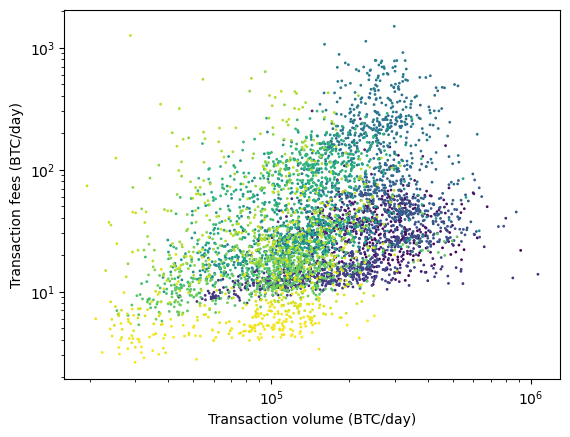

In [9]:
df2 = txn_btc.merge(fees_btc, how='outer', on='Timestamp', sort=True)
df2 = df2.merge(txn_num, how='outer', on='Timestamp', sort=True)
df2 = df2.merge(block_size, how='outer', on='Timestamp', sort=True)
df2.interpolate(method='time', inplace=True)
df2 = df2.loc[df2.index>pd.to_datetime('2012-07-01')]
df2.plot.scatter(x='estimated-transaction-volume',y='transaction-fees',
                 s=1, c=df2.index, cmap='viridis')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Transaction fees (BTC/day)')
plt.xlabel('Transaction volume (BTC/day)')

Text(2.5, 0.8, '@nemozen')

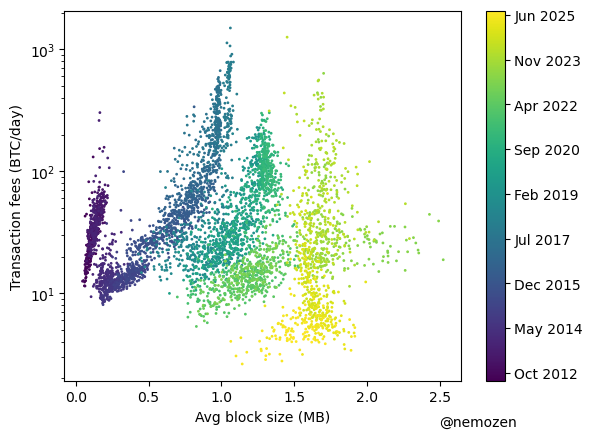

In [10]:
def timestamp_label(t):
    return dt.datetime.fromtimestamp(t/1e9).strftime('%b %Y')

plt.scatter(x=df2['avg-block-size'], y=df2['transaction-fees'],
                 s=1, c=df2.index, cmap='viridis')
plt.yscale('log')
plt.ylabel('Transaction fees (BTC/day)')
plt.xlabel('Avg block size (MB)')
cb=plt.colorbar()
cb.set_ticklabels([timestamp_label(t) for t in cb.get_ticks()])
plt.text(2.5, 0.8, '@nemozen')

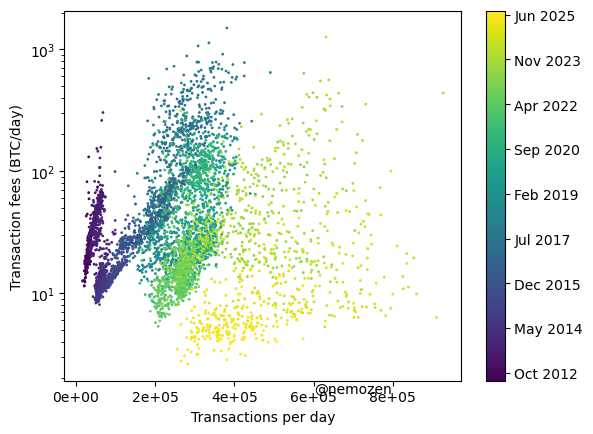

In [11]:
plt.scatter(x=df2['n-transactions'], y=df2['transaction-fees'],
                 s=1, c=df2.index, cmap='viridis')
plt.yscale('log')
#plt.xscale('log')
plt.ylabel('Transaction fees (BTC/day)')
plt.xlabel('Transactions per day')
cb=plt.colorbar()
cb.set_ticklabels([timestamp_label(t) for t in cb.get_ticks()])
plt.text(600000.0, 1.5, '@nemozen')
ax = plt.gca()
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0e}'))

In [12]:
mempool_size = pd.read_csv('mempool-size.csv')
mempool_size.set_index('Timestamp', inplace=True)
mempool_size.index = pd.to_datetime(mempool_size.index)

Text(0.5, 0, 'Mempool size (Bytes)')

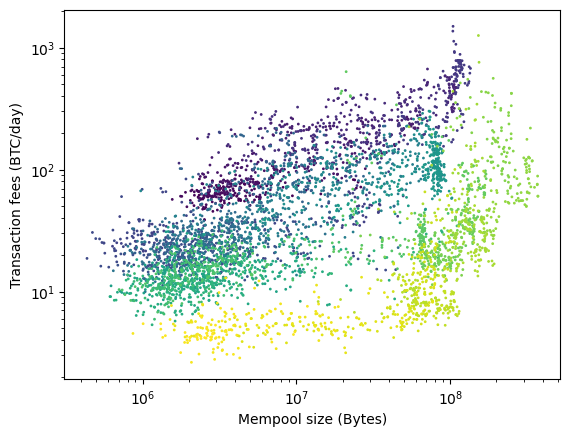

In [13]:
df3 = df2.merge(mempool_size, how='outer', on='Timestamp', sort=True)
df3 = df3.loc[df3.index>pd.to_datetime('2016-06-14')]
df3.interpolate(method='time', inplace=True)
plt.scatter(x=df3['mempool-size'], y=df3['transaction-fees'],
                 s=1, c=df3.index, cmap='viridis')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Transaction fees (BTC/day)')
plt.xlabel('Mempool size (Bytes)')

# Yield

In [14]:
hash_rate = pd.read_csv('hash-rate.csv')
hash_rate.set_index('Timestamp', inplace=True)
hash_rate.index = pd.to_datetime(hash_rate.index)

rewards = pd.read_csv('block-rewards.csv')
rewards.set_index('DateTime', inplace=True)
rewards.index = pd.to_datetime(rewards.index)

Text(0, 0.5, 'BTC/TH')

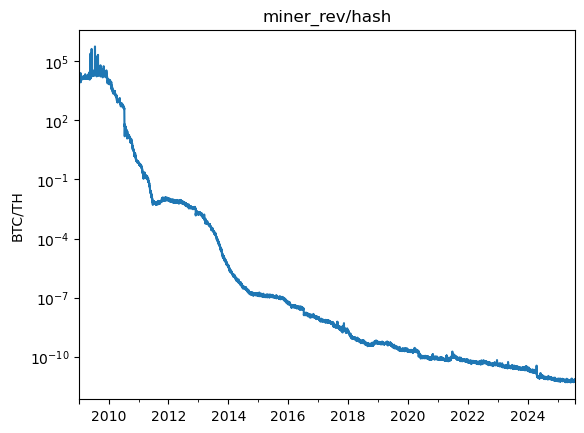

In [15]:
df4 = hash_rate.merge(fees_btc, how='outer',  left_on='Timestamp', right_on='Timestamp', sort=True)
df4 = df4.merge(rewards, how='outer', left_index=True, right_index=True, sort=True)
df4.interpolate(method='time', inplace=True)
rh = df4.apply(lambda row: (row['transaction-fees']/(3600*24) + row['BTC']/600)/row['hash-rate'], axis=1)
rh.plot()
plt.yscale('log')
plt.title('miner_rev/hash')
plt.ylabel('BTC/TH')

Text(2023-04-25, 1e-09, '@nemozen')

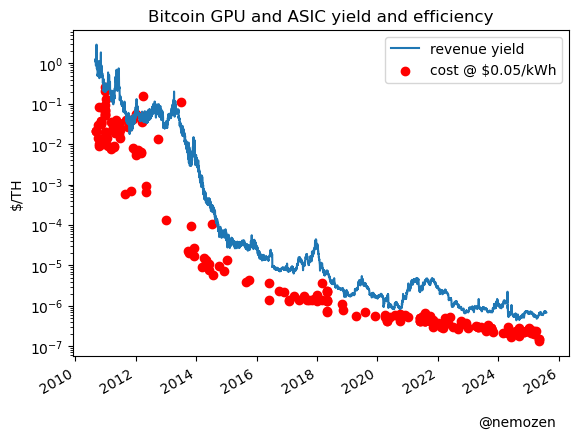

In [16]:
price_kwh = 0.05
df5 = df4.merge(df, how='outer', left_index=True, right_index=True, sort=True)
df5 = df5.loc[df5.index>pd.to_datetime('2010-09-01')]
df5.interpolate(method='time', inplace=True)
rh_usd = df5.apply(lambda row: (row['miners-revenue']/(3600*24))/row['hash-rate'], axis=1)
rh_usd.plot(label='revenue yield')
plt.yscale('log')
plt.ylabel('$/TH')
plt.title('Bitcoin GPU and ASIC yield and efficiency')

plt.scatter(x=miners_df.index, y=miners_df['alpha (kWh/TH)']*price_kwh,
            color='red', label="cost @ ${}/kWh".format(price_kwh))
plt.legend()
plt.text("2023-04-25", 1e-9, '@nemozen')

# Global hash rate and power

Text(0.5, 1.0, 'Global hashrate')

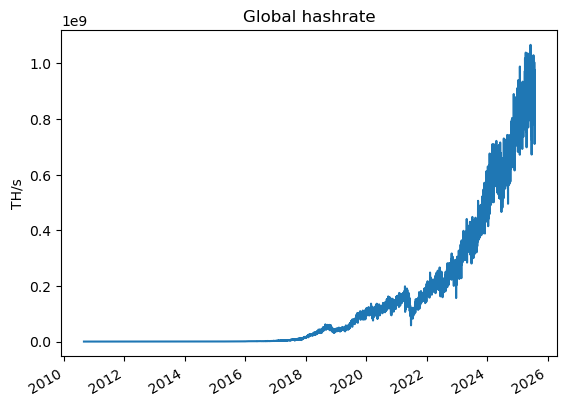

In [17]:
df5['hash-rate'].plot()
plt.ylabel('TH/s')
plt.title('Global hashrate')

## Naive power consumption model (lower bound)

First we compute power consumption assuming that all miners are at the lowest alpha up to that point, i.e. 100% of the population of miners uses the most energy efficient machine available. This is obviously a lower bound on power since older less efficient machines continue to run as long as they are profitable.  

In [18]:
df6 = miners_df.merge(df5, how='outer', left_index=True, right_index=True, sort=True)
df6.interpolate(method='pad', inplace=True)

lower_bound = None
for d in df6.index:
    val = df6.loc[d,'alpha (kWh/TH)']
    if type(val) == pd.Series:
        val = val[-1]
    if not lower_bound or not (lower_bound < val):
        lower_bound = val
    if not (lower_bound > val):
        df6.at[d,'alpha (kWh/TH)'] = lower_bound

Text(0, 0.5, 'kWh/TH')

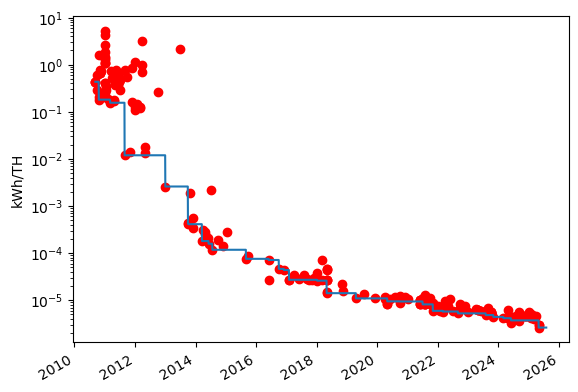

In [19]:
plt.scatter(x=miners_df.index, y=miners_df['alpha (kWh/TH)'], color='red')
df6['alpha (kWh/TH)'].plot()
plt.yscale('log')
plt.ylabel('kWh/TH')

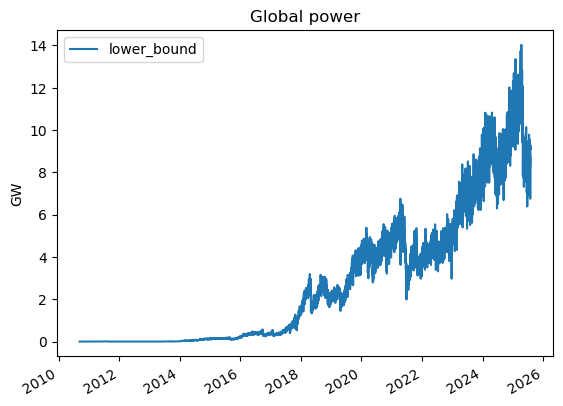

In [20]:
df6.apply(lambda row: row['alpha (kWh/TH)']*row['hash-rate']*3600*1e3/1e9, axis=1).plot(label='lower_bound')
plt.ylabel('GW')
plt.title('Global power')
plt.legend()

## Miner population mix power consumption model

To get a more realistic estimate, let's model how the population distribution evolves as new generations of hardware are introduced.

Let $t_i$ be the time at which the i-th generation of miner is launched. First, assume the cummulative number of units deployed of generation $i$ rises from zero at time $t_i$ asymptotically approaching a maximum $N_i$ but stops growing when the next generation is introduced. More precisely it follows $(1-e^{a(t_i-t)})N_i$ for $t_i < t \leq t_{i+1}$ and then stays constant after $t>t_{i+1}$.  Second, assume each machine has a given chance of dying or being retired which increases depends on how old it is, i.e. an individual machine deployed at time $\tau$ has a probability $e^{b(\tau-t)}$ of being still online at time t. The number of miners of generation $i$ still working at time $t$ is then:
$$P_i(t) = N_i\int_{t_i}^{\min(t, t_{i+1})} x_i(\tau) e^{b(\tau-t)} d\tau$$ 
where $x_i(\tau) = {d \over d\tau} (1 - e^{a(t_i - \tau})) = a e^{a(t_i - \tau)}$ is the number launched at time $\tau$. Substituting that in and solving the integral, the population at time $t$ is, for $t_i < t \leq t_{i+1}$:
$$P_i(t) = N_i{a \over a-b}\left( e^{b(t_i -t)} - e^{a(t_i -t)} \right) $$ 
and for $t >t_{i+1}$:
$$P_i(t) = N_i{a \over a-b}\left( e^{b(t_i -t)} - e^{b(t_{i+1} -t) + a(t_i - t_{i+1})} \right)$$

Our model is that at time $t$, the fraction of the population that is of generation $i$ is $P_i(t)/\sum_j{P_j(t)}$.

We assume

* the growth rate is such that half the potential is reached in half a year, so $a = ln(2)/(0.5yrs)$
* the half-life of a machine is 3 years, so $b = ln(2)/(3yrs)$
* $N_i$ is the same for all $i$ so it cancels out in the population fraction; this is not as unrealistic as it may seem since individual machines hash rate is increasing even as the global hash rate increases, and both increased about an order of magnitude from 2017 to 2021.

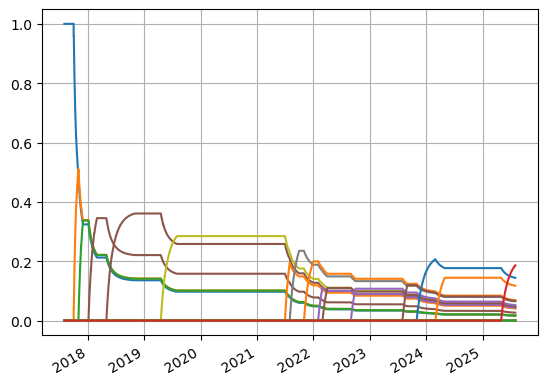

In [21]:
import math

b = math.log(2)/(3*365.25)
a = math.log(2)/(0.1*365.25)

asic_miners = miners_df.loc[miners_df.index>pd.to_datetime('2017-08-01')]
df6 = df6.loc[df6.index>pd.to_datetime('2017-08-01')]

def population_weights(t):
    last_alpha = None
    p = []
    intervals = list(zip(asic_miners.index, list(asic_miners.index[1:]) + [pd.Timestamp.max]))
    for n in range(len(intervals)):
        tn,tn1 = intervals[n] 
        if tn > t:
            pn = 0
        elif last_alpha and asic_miners.iloc[n]['alpha (kWh/TH)'] > last_alpha:
            pn = 0
        else:
            pn = (math.exp(b*(tn-t).days) - 
                  math.exp(a*(tn-min(tn1,t)).days + b*min(tn1-t,pd.Timedelta(0)).days))
            pn *= a/(a-b)
            last_alpha = asic_miners.iloc[n]['alpha (kWh/TH)']
        p.append(pn)
    s = sum(p)
    if s == 0:
        return [1.0] + [0]*(len(p)-1)
    return [pi/s for pi in p]

pop_dist = df6.apply(lambda row: population_weights(row.name), result_type='expand', axis=1)
pop_dist.plot(legend=False)
plt.grid()

This generates the population mix that we can see in the plot above. Comparing it to reports (e.g. that [machines released in 2017 had ~23% share in mid 2020](https://www.theblockcrypto.com/post/63892/report-bitcoin-antminer-s9-bitcoin-hash-rate)) seems to indicate our estimate of adoption rate is realistic but on the conservative side, and since machines are getting more efficient, it will give a reasonably tight upper bound on power consumption.

## Population-based power (upper bound)

Text(2025-01-01, -5, '@nemozen')

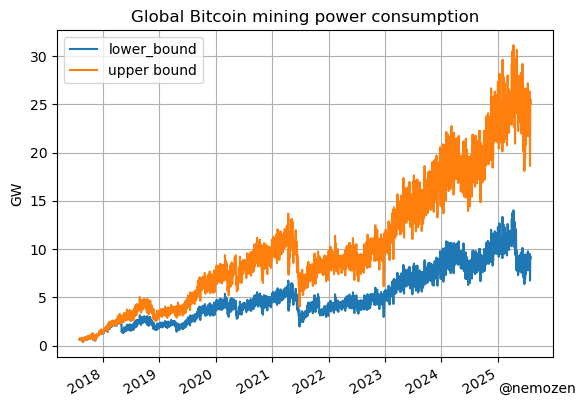

In [22]:
df6.apply(lambda row: row['alpha (kWh/TH)']*row['hash-rate']*3600/1e6, axis=1).plot(label='lower_bound')
df6['alpha avg']=pop_dist.apply(lambda row: row.dot(asic_miners['alpha (kWh/TH)'].values), axis=1)
df6.apply(lambda row: row['alpha avg']*row['hash-rate']*3600/1e6, axis=1).plot(label='upper bound')
plt.ylabel('GW')
plt.title('Global Bitcoin mining power consumption')
plt.legend()
plt.grid()
plt.text("2025-01-01", -5, '@nemozen')